# Cognitive Services for Facial Recognition
### Online Talk for DevelopersBR<br>Subject: Using Azure Cognitive Services for Facial Recognition<br>Date: Jan, 31 2020

**After this notebook, you'll be able to:**
- Store images in a "database" for using in facial recognition
- "Train" model with faces database, generating face embeddings (faceprints)
- Run face recognition on a new image
- Draw Bounding Boxes for face matches, with info (confidence/accuracy, name)
- Draw Bounding Boxes for face unmatches, with "unknown label"


**Let's start ... Importing libraries**

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import cognitive_face as CF # Microsoft Face API SDK
import cv2 # Open CV
from imutils import paths # Image utils from pyimagesearch (Adrian Rosebrock)
from matplotlib import pyplot as plt

import collections
import time
import zipfile
import requests
import json
import os
import configparser
import time

## 0. Helper Functions

In [2]:
def image2bytes(filename):
    """ 
    Convert a imagefile in bytes

    Parameters:
    filename (str): Image file to convert (with relative path to notebook folder)

    Returns:
    bytes: Array of bytes from image file

    """
        
    with open(filename, 'rb') as image_file:
        image_bytes = image_file.read()
    
    return image_bytes

In [3]:
def read_config_file(config_file):
    """ 
    Read config file with API Keys for Cognitive Services

    Parameters:
    config_file (str): Config file to read (inside config folder of this project)

    Returns:
    config (dict) - Dictionary for Config File

    """
    
    config = configparser.RawConfigParser()
    config.read('../config/' + config_file)  
    
    return config

In [4]:
def get_config_section(config):
    """ 
    Return config sections populated by read_config_file function

    Parameters:
    config (dict) - Config sections

    Returns:
    config_key (str) - Content of specific key in specific section at config file

    """
    
    if not hasattr(get_config_section, 'section_dict'):
        get_config_section.section_dict = dict()
        for section in config.sections():
            get_config_section.section_dict[section] = dict(config.items(section))
            
    return get_config_section.section_dict

In [5]:
def create_zipfiles(dataset):
    
    """ 
    Create Zip files for each folder (Person) in dataset

    Parameters:
    dataset (str): Folder containing image dataset, relative to this project folder

    Returns:
    subdirs (array): List of subdirs (Person Names)

    """
    
    start_ts = time.time()

    subdirs = [o for o in os.listdir('../' + dataset) if os.path.isdir(os.path.join('../' + dataset,o))]
    
    for name in subdirs:
        zf = zipfile.ZipFile('../' + dataset + "/" + name + ".zip", "w")
        files = [x for x in os.listdir('../' + dataset + "/" + name)]
        for filename in files:
            zf.write(os.path.join('../' + dataset + "/" + name, filename), filename)
        zf.close()
        
    print(f"Zipping time: {time.time()-start_ts} seconds")
        
    return subdirs

In [6]:
# Read Config Files
config = read_config_file('config_example.properties')
config_dict = get_config_section(config)

In [7]:
config_dict

{'Microsoft': {'key': '76a7b3bae56f4187bcb64e8f15184be5',
  'base_url': 'https://eastus.api.cognitive.microsoft.com/face/v1.0'}}

In [8]:
# Variables for this experiment
person_group = 'guns'          # Person Group Id for Microsoft Face API
person_group_name = 'Person Group - Guns'   # Person Group Name for Microsoft Face API

## 1. Store images for using in a facial recognition task

Collect pictures with faces, label them with person names and finally store in database, bucket or storage, in a way it can possible to apply some embeddding / encoding algorithm to transform this face in a faceprint.

**Microsoft Face API:**
- Create Person Group object to store all Persons to be identified
- Create Person object into Person Group
- Detect Face in each image
- Add images into Person Group and Person, using bounding box

In [10]:
def configure_faceapi():
    
    """ 
    Configure access to Microsoft Face API

    Parameters:
    none

    Returns:
    none

    """
    
    # Set Key to SDK
    KEY = config_dict['Microsoft']['key']
    CF.Key.set(KEY)

    # Set BASE_URL to SDK    
    BASE_URL = config_dict['Microsoft']['base_url']
    CF.BaseUrl.set(BASE_URL)    

In [11]:
def store_images_azure(dataset, person_group, person_group_desc):
    """
    Read a image dataset and store in Azure Face API Service

    Parameters:
    dataset (str): Folder containing image dataset, relative to this project folder
    person_group (str): Code / Mnemonic for Person Group
    person_group_desc (str): Description of Person Group

    Returns:
    none

    """
    
    start_ts = time.time()

    # Create person Group
    CF.person_group.create(person_group, person_group_desc)

    # list folders with person names, inside dataset folder
    imagePaths = list(paths.list_images('../' + dataset))
    
    currentPerson = None
    
    # iterate into images dataset
    for (i, imagePath) in enumerate(imagePaths):
        print("Storing image metadata {}/{} in Azure".format(i + 1, len(imagePaths)))
        # extract the person name from the image path
        personName = imagePath.split(os.path.sep)[-2]
        
        if personName != currentPerson:
            person_id = CF.person.create(person_group, personName)
            currentPerson = personName
        
        faces = CF.face.detect(imagePath)
        if len(faces) > 0:
            top = faces[0]['faceRectangle']['top']
            left = faces[0]['faceRectangle']['left']
            width = faces[0]['faceRectangle']['width']
            height = faces[0]['faceRectangle']['height']
            
            bounding_box = str(left)+","+str(top)+","+str(width)+","+str(height)
                        
            CF.person.add_face(imagePath, person_group, person_id['personId'], target_face=bounding_box)
        
        time.sleep(6)
                
    print(f"Storing time: {time.time()-start_ts} seconds")

In [12]:
# run code for store images - Microsoft Azure
configure_faceapi()
store_images_azure('dataset', person_group, person_group_name)

Storing image metadata 1/30 in Azure
Storing image metadata 2/30 in Azure
Storing image metadata 3/30 in Azure
Storing image metadata 4/30 in Azure
Storing image metadata 5/30 in Azure
Storing image metadata 6/30 in Azure
Storing image metadata 7/30 in Azure
Storing image metadata 8/30 in Azure
Storing image metadata 9/30 in Azure
Storing image metadata 10/30 in Azure
Storing image metadata 11/30 in Azure
Storing image metadata 12/30 in Azure
Storing image metadata 13/30 in Azure
Storing image metadata 14/30 in Azure
Storing image metadata 15/30 in Azure
Storing image metadata 16/30 in Azure
Storing image metadata 17/30 in Azure
Storing image metadata 18/30 in Azure
Storing image metadata 19/30 in Azure
Storing image metadata 20/30 in Azure
Storing image metadata 21/30 in Azure
Storing image metadata 22/30 in Azure
Storing image metadata 23/30 in Azure
Storing image metadata 24/30 in Azure
Storing image metadata 25/30 in Azure
Storing image metadata 26/30 in Azure
Storing image metadat

## 2. "Train" model with faces database, generating face embeddings (faceprints)

Read a collection of images from storage and generate embeddding / encoding algorithm to transform this face in a faceprint.

**Microsoft Face API:**
- Train model in Person Group

In [13]:
def train_faceapi(person_group):
    """
    Train a Person Group

    Parameters:
    person_group (str): Name of Person Group

    Returns:
    none

    """
    
    start_ts = time.time()
    
    CF.person_group.train(person_group)
    
    i = 1
    status = 'Pending'
    
    while (status != 'succeeded'):
        print("Training - Step {}".format(i))
        response = CF.person_group.get_status(person_group)
        status = response['status']
        i =+ 1
        
    print(f"Training time: {time.time()-start_ts} seconds")

In [14]:
# run code for training - Microsoft Face API
train_faceapi(person_group)

Training - Step 1
Training time: 1.4199020862579346 seconds


## 3. Run face recognition on a new image

With a new captured image, execute facial recognition, search new image in embeddings database

In [17]:
new_image_known_face1 = '../test/axltest.png'
new_image_known_face2 = '../test/dufftest.jpg'
new_image_known_face3 = '../test/slashtest.jpg'
new_image_unknown_face = '../test/joetest.jpg'

**Microsoft Face API:**
- Run face detect and identify using data stored and trained in Person Group

In [18]:
def face_recognition_microsoft(person_group, image, threshold):
    """
    Execute Face Recognition in Person Group defined in Azure Cognitive Face API

    Parameters:
    person_group (str): Name of Person Group
    image (str): Image file to recognize face (with relative path to notebook folder)
    threshold (int): Threshold for Face Recognition

    Returns:
    personname (str): Person Name
    bounding_box (dict): Bounding box with face detected in image. Format: Top, Left, Width, Height
    confidence (float): Confidence level in percentage (accuracy)

    """
    
    start_ts = time.time()

    # Run Face Detection with new image
    faces = CF.face.detect(image)
    face_ids = [f['faceId'] for f in faces]
    
    if len(faces) > 0:
        top = faces[0]['faceRectangle']['top']
        left = faces[0]['faceRectangle']['left']
        width = faces[0]['faceRectangle']['width']
        height = faces[0]['faceRectangle']['height']

        bounding_box = {'Top': top, 'Left': left, 'Width': width, 'Height': height}
    
        face_matches = CF.face.identify(face_ids, person_group)
        
        if len(face_matches[0]['candidates']) > 0:
            person = CF.person.get(person_group, face_matches[0]['candidates'][0]['personId'])
            personname = person['name']
            confidence = face_matches[0]['candidates'][0]['confidence']
        else:
            personname = 'Unknown'
            confidence = 0.0
            
    print(f"Recognition time: {time.time()-start_ts} seconds")
    
    return personname, bounding_box, confidence

In [28]:
# run facial recognition (Known Face) - Microsoft Face API
personname_microsoft, bounding_box_microsoft, confidence_microsoft = face_recognition_microsoft(person_group, new_image_known_face2, 50)

Recognition time: 2.1833689212799072 seconds


In [30]:
# run facial recognition (Unknown Face) - Microsoft Face API
personname_microsoft_u, bounding_box_microsoft_u, confidence_microsoft_u = face_recognition_microsoft(person_group, new_image_unknown_face, 90)

Recognition time: 1.6340858936309814 seconds


## 4. Draw Bounding Boxes for face matches, with info (confidence/accuracy, name)

Read data from facial recognition, check face matches and draw a bounding box with name and confidence/accuracy in the new image

**Microsoft**
- Use a helper function (OpenCV) to draw a bounding box, passing facial recognition data, image and box info (Person Name and Accuracy)

In [20]:
def draw_bounding_boxes(box, personname, accuracy, image):
    """
    Draw Bounding Box in image, with Person Name or Unknown and Accuracy Level
    
    Parameters:
    bounding_box (dict): Bounding box with face detected in image. Format: Top, Left, Width, Height
    personname (str): Person Name
    accuracy (float): Accuracy level in percentage
    image (str): Image file to draw bounding box (with relative path to notebook folder)

    Returns:
    none
    
    """

    # display the image to our screen
    img1 = cv2.imread(image)

    left = box['Left']
    top = box['Top']
    width = box['Width']
    height = box['Height']
    
    label = personname + '/' + str(accuracy)

    cv2.rectangle(img1, (left, top), (left + width, top + height), (255, 0, 0), 5)
    y = top - 15 if top - 15 > 15 else top + 15
        
    cv2.putText(img1, label, (left, y), cv2.FONT_HERSHEY_SIMPLEX, 1.00, (255, 0, 0), 5)

    plt.imshow(img1)
    plt.title('Image')
    plt.show()

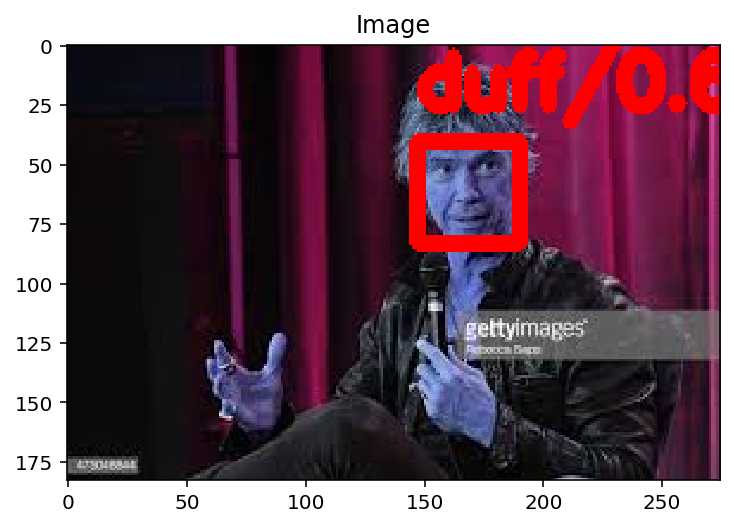

In [29]:
# run draw bounding boxes (face matches) - Microsoft
draw_bounding_boxes(bounding_box_microsoft, personname_microsoft, confidence_microsoft, new_image_known_face2)

## 5. Draw Bounding Boxes for face unmatches, with unkwown tag

Read data from facial recognition, check face unmatches and draw a bounding box with unknown tag in the new image

**Microsoft:**
- Use a helper function (OpenCV) to draw a bounding box, passing face recognition data, image and box info (Unknown)

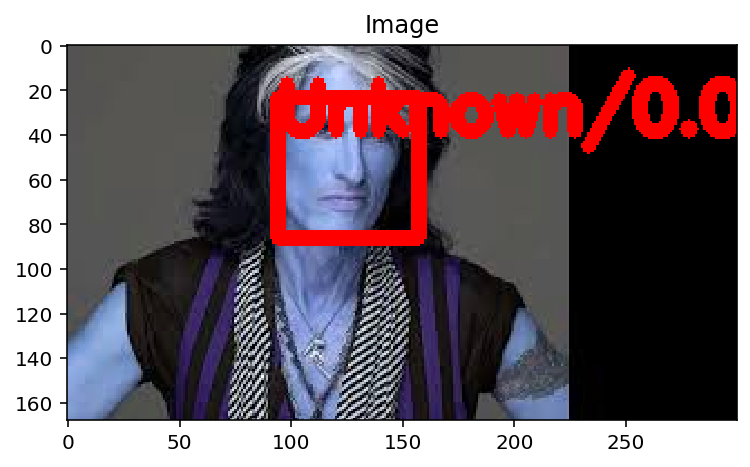

In [31]:
# run draw bounding boxes (face unmatches) - Microsoft
draw_bounding_boxes(bounding_box_microsoft_u, personname_microsoft_u, 0.0, new_image_unknown_face)

**Useful links that helped me build this notebook**

- https://docs.microsoft.com/en-us/azure/cognitive-services/Face/Tutorials/FaceAPIinPythonTutorial
- https://docs.microsoft.com/en-us/python/api/overview/azure/cognitiveservices/faceapi?view=azure-python
- https://github.com/microsoft/Cognitive-Face-Python/
- https://clemenssiebler.com/face-recognition-with-azure-cognitive-services-face-api/